In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"

In [6]:
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    #r_map[p_map >= 1e-8]=0
    
    maps[behavior] = r_map

In [9]:
norm_min = 0
norm_max = np.max(np.nan_to_num(maps['Y_pos']))
norm_max = 0.1#0.15
slices = []
for z in range(49):
    #colors1 = Normalize(norm_min, norm_max)(maps['Z_neg'][z,:,:].T)
    colors2 = Normalize(norm_min, norm_max)(maps['Z_pos'][z,:,:].T)
    #colors3 = Normalize(norm_min, norm_max)(maps['Y_pos'][z,:,:].T)
    #to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(colors2)

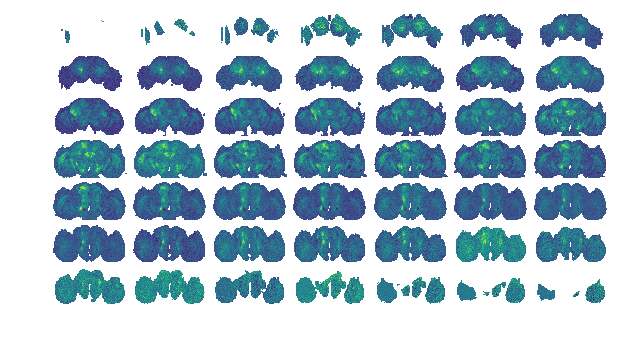

In [10]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(slices[i]*2);
    grid[i].axis('off')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [69]:
slices = np.asarray(slices)
slices = np.moveaxis(slices,0,2)
slices.shape

(128, 256, 49, 3)

In [70]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke.nii'
anatomy = np.asarray(nib.load(file).get_data(), dtype='float32')/1
anatomy = np.moveaxis(anatomy,0,1)
anatomy.shape

(512, 1024, 256)

In [71]:
# Both Y,X,Z - good

#### Interpolate both to be 1um isotropic

In [72]:
# When I was aligning my functional data to the anatomical average, I resampled the anat down to match the
# dimensions of the functional
# This new space does not have um units of the functional, but actually the anat

In [73]:
anatomy_iso = ants.resample_image(ants.from_numpy(anatomy),(int(512*0.65), int(1024*0.65), int(256*1)),1,0).numpy()

In [74]:
slices_iso = ants.resample_image(ants.from_numpy(slices),(int(512*0.65), int(1024*0.65), int(256*1), 3),1,1,).numpy()

In [75]:
anatomy_iso.shape, slices_iso.shape

((332, 665, 256), (332, 665, 256, 3))

In [76]:
# Alpha Mask
avg_value = np.mean(np.nan_to_num(slices_iso),axis=-1)
mask = np.zeros(np.shape(avg_value))
mask[np.where(avg_value>0)] = 1
to_plot = np.concatenate((slices_iso, mask[:,:,:,np.newaxis]),axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


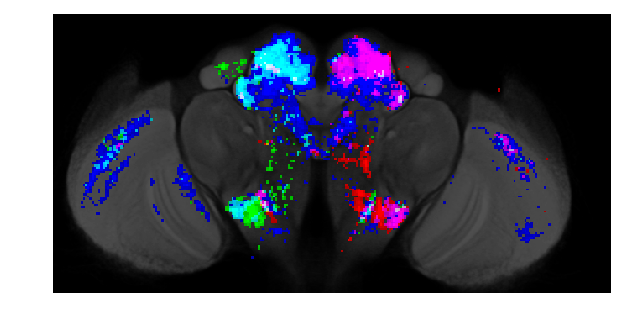

In [79]:
plt.figure(figsize=(10,10))
z=140
plt.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
plt.imshow(to_plot[:,:,z]*2)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


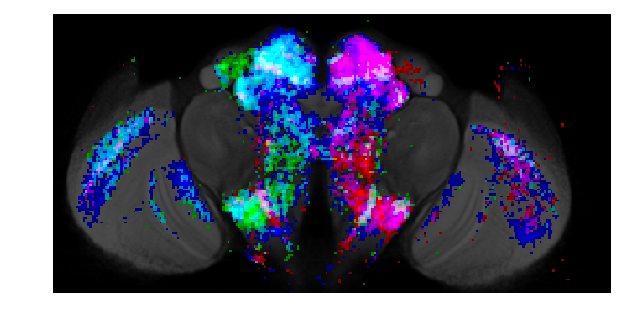

In [66]:
plt.figure(figsize=(10,10))
z=140
plt.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
plt.imshow(to_plot[:,:,z]*2)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [2]:
to_load = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/rvalues_Y_pos_z20.npy'
data = np.load(to_load)

In [3]:
data.shape

(32768,)

In [4]:
data2 = np.reshape(data, (256,128))

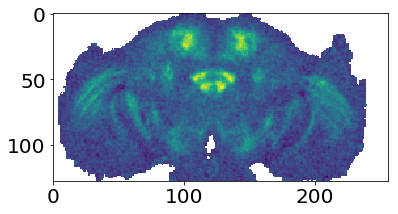

In [6]:
plt.imshow(data2.T)

In [3]:
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(20) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)
brain.shape

(256, 128, 3384, 10)

In [4]:
class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [5]:
class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)

            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)

            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

In [9]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

fly_names = ['fly_087']
z=20

In [10]:
###################
### Build Flies ###
###################
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac(z)
    flies[fly].load_brain_slice()
    #flies[fly].get_cluster_averages(cluster_model_labels, n_clusters)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.92 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.84 sec


In [11]:
flies['fly_087'].brain.shape

(256, 128, 3384)

In [12]:
X = flies['fly_087'].brain[100,:,:]
X.shape

(128, 3384)

In [14]:
Y = flies['fly_087'].fictrac.fictrac['Y_pos']
Y.shape

(3384,)

In [15]:
test = np.corrcoef(X,Y)

In [16]:
test.shape

(129, 129)

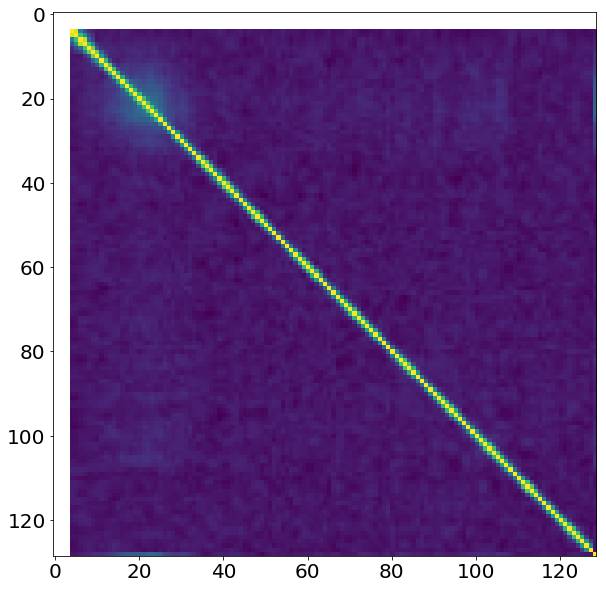

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(test)